In [1]:
%pylab inline
import pandas as pd
import numpy as np
import dill
from string import atoi
import geojson as gj

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getstat(idx):
    return table_stations[table_stations.id==idx]
def getpark(idx):
    return table_pbike[table_pbike.id==idx]
def dstr(x):
    out = u""
    x = x.values[0]
    for i,j in x.iteritems():
        if 'source' not in i:
            out +=u"{0:s}:{1:s} -- \n".format(i,j)
    return out.strip()

In [3]:
table_pbike = pd.read_pickle('table_pbike.pkl')
table_stations = pd.read_pickle('table_stations.pkl')

In [5]:
trafic_entrant_RATP= pd.read_json(open('trafic-annuel-entrant-par-station-du-reseau-ferre-2016.json','r'))

In [6]:
columns = trafic_entrant_RATP.fields.iat[0].keys()
trafic_entrant_RATP = pd.DataFrame(data=trafic_entrant_RATP.fields.values.tolist(),columns=columns)

In [7]:
# (failed) attempt to associate each metro entrance with its entrance trafic 
# I guess that the best way is to make ad-hoc overpass API queries

In [8]:
import unidecode
from fuzzywuzzy import fuzz

In [9]:
simple_stations = trafic_entrant_RATP.station.apply(lambda x:unidecode.unidecode(x).lower()).tolist()

def get_station_from_name(name):
    name = unidecode.unidecode(name)
    station =  [(j,fuzz.token_set_ratio(name,j)) for j in simple_stations ]
    if len(station):
        station = sorted(station,key=lambda x:x[1])[-1]
        if station[1]>90:
            return station[0]
    return None

In [10]:
def get_name_or_none(x):
    keys = ['station','wikipedia','name','alt_name','short_name']
    ops  = [lambda x: x.strip(),
            lambda x: x.split(':')[1].split('(')[0].strip(),
            lambda x: x.split(' - ')[0].strip(),
            lambda x: x.split('- S')[0].strip(),
            lambda x: x.strip()]
    for k,o in zip(keys,ops):
        try:
            return o(x[k])
        except:
            pass
    return None
    
def get_stat_from_tag(tag):
    name = get_name_or_none(tag)
    if name:
        stat = get_station_from_name(name)
        return stat
    else:
        return name
stations = table_stations.tags.apply(get_stat_from_tag)

In [11]:
stations.describe()

count              640
unique             200
top       saint-lazare
freq                16
Name: tags, dtype: object

In [12]:
# Uff.. why not using the overpass api to get the station by name, then look around to find exits, and then parks?

In [13]:
# average number of unique ppl entering a metro station in a year in paris
print 'mean: %.0f' % (trafic_entrant_RATP[trafic_entrant_RATP.arrondissement_pour_paris>0].trafic.mean()/365.)
print 'std : %.0f' % (trafic_entrant_RATP[trafic_entrant_RATP.arrondissement_pour_paris>0].trafic.std()/365.)

mean: 13925
std : 18242


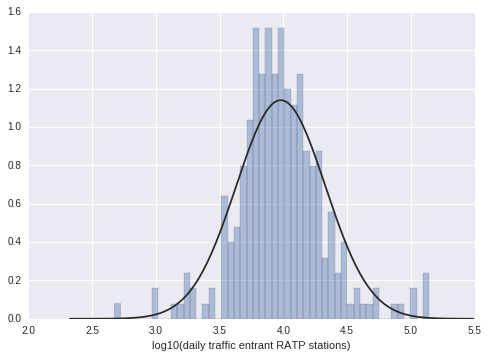

In [14]:
import seaborn as sns
from scipy.stats import norm,poisson
stuff = trafic_entrant_RATP[trafic_entrant_RATP.arrondissement_pour_paris>0].trafic
sns.distplot(stuff.apply(lambda x:np.log10(x/365.)),bins=50,fit=norm,kde=0)
plt.gca().set_xlabel('log10(daily traffic entrant RATP stations)')

In [15]:
data = dill.load(open('top10s.dill','rb'))
stat2park = data['stat2park']
park2stat = data['park2stat']

In [16]:
distances0 = [d[0][0]*1000 for d in park2stat]
distances1 = [d[1][0]*1000 for d in park2stat]
distances2 = [d[2][0]*1000 for d in park2stat]

Populating the interactive namespace from numpy and matplotlib


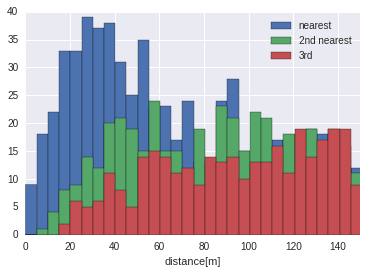

In [22]:
%pylab inline
import pylab as plt
bins = np.linspace(0,1000,200)

cs=False
plt.hist(distances0,bins=bins,cumulative=cs);
plt.hist(distances1,bins=bins,cumulative=cs);
plt.hist(distances2,bins=bins,cumulative=cs);
plt.xlim(0,150)
plt.gca().set_xlabel('distance[m]')
plt.gca().legend(['nearest','2nd nearest','3rd'])

In [66]:
tmp=[]
for row_stat in park2stat:
    for pbike in row_stat:
        d,(_,idpark)=pbike
        park=getpark(idpark)
        capacity = np.nan
        try:
            capacity = park.tags.values[0]['capacity']
            capacity = atoi(capacity)
            tmp.append({'distance':d,
                        'capacity':capacity,
                        'ids':park.id.values[0]})
        except KeyError:
            pass

df = pd.DataFrame(columns=['distance','ids','capacity'],data=tmp)
df.sort_values('distance',inplace=True)
df.drop_duplicates(subset='ids',inplace=True)
df.dropna(inplace=True)

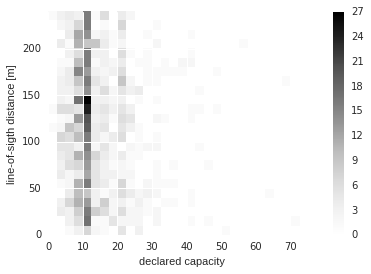

In [67]:
import seaborn as sns
# plt.hist2d(df.capacity,df.distance*1000,bins=[np.arange(0,80,2.5),np.arange(0,250,10)]);
plt.hist2d(df.capacity,df.distance*1000,bins=[np.arange(0,80,2.5),np.arange(0,250,10)]);
plt.xlabel('declared capacity')
plt.ylabel('line-of-sigth distance [m]')
plt.colorbar()

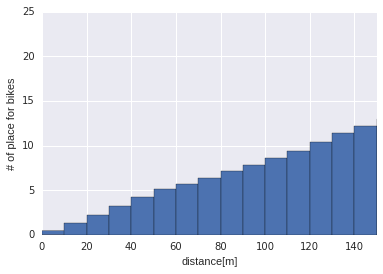

In [68]:
plt.hist(df.distance*1000,weights=df.capacity*1./len(park2stat),bins=np.arange(0,5000,10),cumulative=1);
plt.xlim(0,150)
plt.xlabel('distance[m]')
plt.ylabel('# of place for bikes')

In [69]:
## Make geojson
from tqdm import tqdm_notebook as tqdm

In [70]:
from urllib2 import urlopen
import json
import polyline


#!/usr/bin/env python

import sys

#six degrees of precision in valhalla
inv = 1.0 / 1e6;

#decode an encoded string
def decode(encoded):
    decoded = []
    previous = [0,0]
    i = 0
    #for each byte
    while i < len(encoded):
    #for each coord (lat, lon)
    ll = [0,0]
    for j in [0, 1]:
        shift = 0
        byte = 0x20
        #keep decoding bytes until you have this coord
        while byte >= 0x20:
            byte = ord(encoded[i]) - 63
            i += 1
            ll[j] |= (byte & 0x1f) << shift
            shift += 5
        #get the final value adding the previous offset and remember it for the next
        ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
        previous[j] = ll[j]
    #scale by the precision and chop off long coords also flip the positions so
    #its the far more standard lon,lat instead of lat,lon
    decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
    #hand back the list of coordinates
    return decoded

def route_p2p_osrm(p1,p2,mode='driving'):
    """
        ask to the local OSRM the way from p1 to p2
        p1:(lon, lat)
        p2:(lon,lat)
    """
    route_url="http://localhost:5000/route/v1/{mode:s}/{lon1:.5f},{lat1:.5f};{lon2:.5f},{lat2:.5f}?geometries=geojson&overview=full&steps=false"
    ((lon1,lat1),(lon2,lat2))=p1,p2
    request = route_url.format(lat1=lat1,lon1=lon1,lat2=lat2,lon2=lon2,mode=mode)
    response = urlopen(request).read()
    route = json.loads(response)

    distance = route['routes'][0]['distance']
    path = route['routes'][0]['geometry']
    
    return distance,path

route_p2p_osrm((2.30095, 48.83950),(2.301319, 48.83951))

(48.3,
 {u'coordinates': [[2.300951, 48.839534],
   [2.300951, 48.839534],
   [2.300878, 48.839548],
   [2.30114, 48.839635],
   [2.301261, 48.839656],
   [2.301309, 48.839581],
   [2.301272, 48.839568]],
  u'type': u'LineString'})

In [71]:
features = []
points = []
lines  = []
def capacity_to_color(x):
    if x>20:return "#00ff00"
    if x>10:return "#0000ff"
    if x>5 :return "#ff0000"
    return "#cccccc"


for row_stat in tqdm(park2stat):
    d,(idstat,idpark)=row_stat[0]
    stat = getstat(idstat)    
    slat = stat.lat.values[0]
    slon = stat.lon.values[0]
    lin = []
    for pbike in row_stat:
        d,(_,idpark)=pbike
        park=getpark(idpark)
        # attributes
        lat = park.lat.values[0]
        lon = park.lon.values[0]
        try:
            capacity = park.tags.values[0]['capacity']
            capacity = atoi(capacity)
        except:
            capacity = -1
        d,line = route_p2p_osrm((lon,lat),(slon,slat))
        if d<=100:
            
            p = gj.Point((lon,lat))
            p = gj.Feature(geometry=p,properties={'title':'capacity {0:d}'.format(capacity),
                                                  "marker-color": "#ffffff",   
                                                  "marker-symbolcolor": capacity_to_color(capacity)})
            points.append(p)
            lin.append(line['coordinates'])
    lines.append(gj.Feature(geometry=gj.MultiLineString(lin),properties={}))
    
points.extend(lines)
with open('within100m.geojson','w') as fout:
     print >> fout, gj.dumps(gj.FeatureCollection(points))

Widget Javascript not detected.  It may not be installed or enabled properly.


## Interactive map

In [26]:
from IPython.core.display import HTML

print 'do not donwload the easymap library. I made changes to the sourcecode to remove the shadow and improve speed'
# !wget https://raw.githubusercontent.com/Lapizistik/leaflet-easymap/master/js/leaflet-easymap.js
# !mkdir js
# !mv leaflet-easymap.js js -v

do not donwload the easymap library. I made changes to the sourcecode to remove the shadow and improve speed


In [25]:
page="""<html>
<head>
    <!-- include leaflet css and javascript -->
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.1.0/dist/leaflet.css" />
    <script src="https://unpkg.com/leaflet@1.1.0/dist/leaflet.js" ></script>

    <!-- the leaflet easymap javascript -->
    <!-- include this _after_ the leaflet javascript -->
    <script src="js/leaflet-easymap.js"></script>
        
    <style type="text/css">
      .leasymap {
        /* Important: the element needs a height! */
        height: 500px; /* adjust this as you need it */
        width: 100%; /* adjust this as you need it */
        /* the following css is optional */
        border: 0px solid black;
        margin:5px;
      }
    </style>
</head>
<body>
    <a href='parkmybike.html' target=_blank>open me </a>
    <div class="leasymap" data-locate="true" data-geojson="within100m.geojson" data-origin="geojson"></div>
</body>
</html>
"""
with open('parkmybike.html','w') as fout:
    print >> fout,page

HTML(page)

In [ ]:
from IPython.core.